In [1]:
from map_generator import MapGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
from Planners.abc.abc_problem import ABCProblem
from Planners.pso.pso_problem import PSOProblem
from Planners.gwo.gwo_problem import GWOProblem
from Planners.a_star.a_star import AStarPlanner
from Planners.util.planner_base import PlannerBase
from Planners.helper import linear_interpolation
from IPython.display import display, clear_output

In [39]:
map_details = {
    'map1': {
        'file_name': 'custom_map_2_params.yaml',
        'start': [100, 400],
        'end': [400, 100],
        'points': 1
    },
    'map2': {
        'file_name': 'custom_map_4_params.yaml',
        'start': [50, 250],
        'end': [250, 250],
        'points': 2
    },
    'map3': {
        'file_name': 'custom_map_3_params.yaml',
        'start': [50, 450],
        'end': [300, 100],
        'points': 3
    },
    'map4': {
        'file_name': 'custom_map_1_params.yaml',
        'start': [600, 800],
        'end': [1700, 500],
        'points': 3
    },
    'map5': {
        'file_name': 'map_012_params.yaml',
        'start': [250, 1750],
        'end': [1100, 200],
        'points': 3
    }
}

In [36]:
def get_path_cost(curr_map, path):
    length = 0
    violations = 0
    prev_x, prev_y = path[0]
    prev_cost = curr_map[prev_y, prev_x]
    root_2 = 2 ** 0.5
    for curr_x, curr_y in path[1:]:
        if curr_x == prev_x or curr_y == prev_y:
            length += 1
        else:
            length += root_2
        curr_cost = curr_map[curr_y, curr_x]
        if curr_cost != prev_cost and curr_cost == 0:
            violations += 1
        prev_cost = curr_cost
    return length, violations

In [32]:
class ParticleWarehouse:
    def __init__(self, parent_dir):
        if not os.path.exists(parent_dir):
            os.mkdir(parent_dir)
        self.parent_dir = parent_dir
    
    def get_callback(self, curr_map, curr_planner, run):
        store_dir = os.path.join(self.parent_dir, curr_map)
        if not os.path.exists(store_dir):
            os.mkdir(store_dir)
        store_dir = os.path.join(store_dir, curr_planner)
        if not os.path.exists(store_dir):
            os.mkdir(store_dir)
        store_dir = os.path.join(store_dir, 'run_%d' % run)
        if not os.path.exists(store_dir):
            os.mkdir(store_dir)
        def curr_callback(iteration, particle):
            file_name = os.path.join(store_dir, 'particle_%d.txt' % iteration)
            np.savetxt(file_name, particle)
            print('Completed iteration', iteration+1)
        return curr_callback
    
    def save_result(self, file_name, data_df):
        file_path = os.path.join(self.parent_dir, file_name)
        data_df.to_csv(file_path, index=False)

In [15]:
planner_params = {
    'ABC Optimizer': {
        'optimizer': ABCProblem,
        'optimizer_params': {
            'iteration_number': 40,
            'bees': 10,
            'high_step_prob': 0.3
        },
        'cost_func_wt': (2, 1)
    },
    'GWO Optimizer': {
        'optimizer': GWOProblem,
        'optimizer_params': {
            'iteration_number': 40,
            'wolves': 20
        },
        'cost_func_wt': (2, 1)
    },
    'PSO Optimizer': {
        'optimizer': PSOProblem,
        'optimizer_params': {
            'iteration_number': 40,
            'particles': 20,
            'weight': 0.5,
            'c_1': 1.5,
            'c_2': 1.5
        },
        'cost_func_wt': (2, 1)
    }
}

In [40]:
results = pd.DataFrame({
    'map_file':pd.Series(dtype='str'),
    'planner_name': pd.Series(dtype='str'),
    'run': pd.Series(dtype='int'),
    'time_taken': pd.Series(dtype='float'),
    'distance': pd.Series(dtype='float'),
    'violation': pd.Series(dtype='float')
})

total_runs = 5
warehouse = ParticleWarehouse('testing_2')

map1-ABC Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


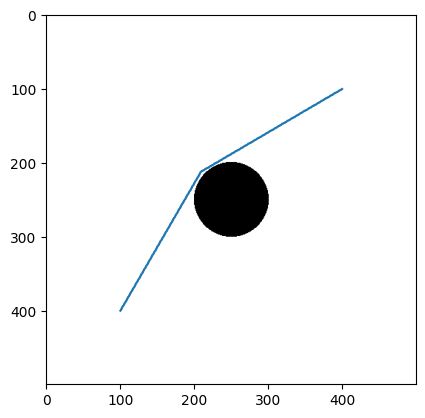

map1-ABC Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


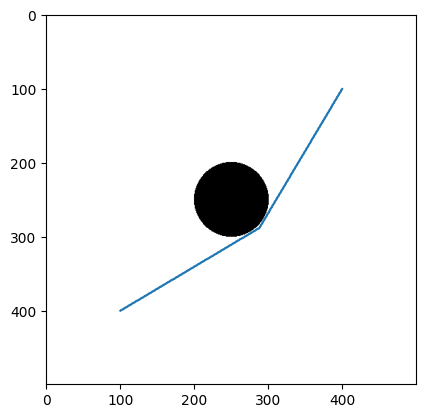

map1-ABC Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


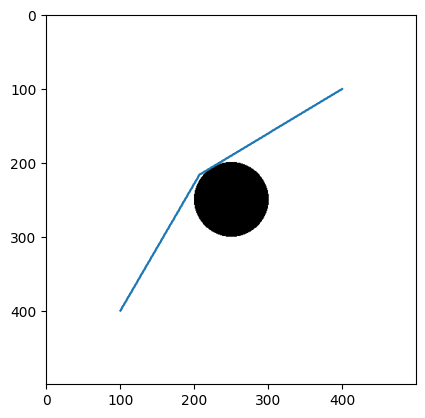

map1-ABC Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


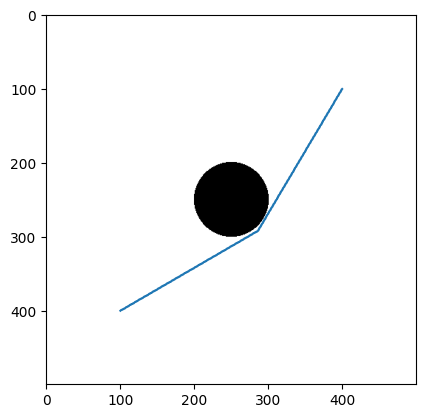

map1-ABC Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


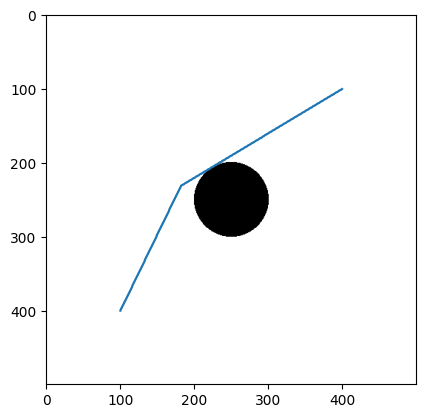

map1-GWO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


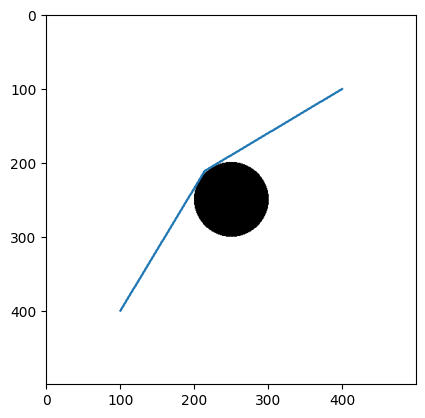

map1-GWO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


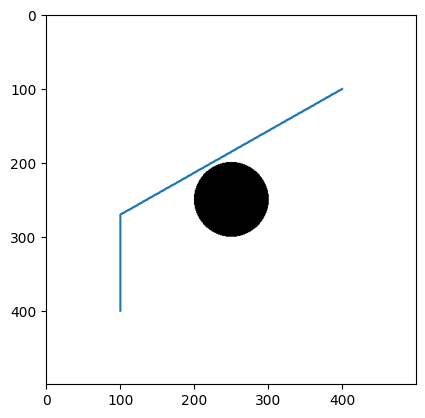

map1-GWO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


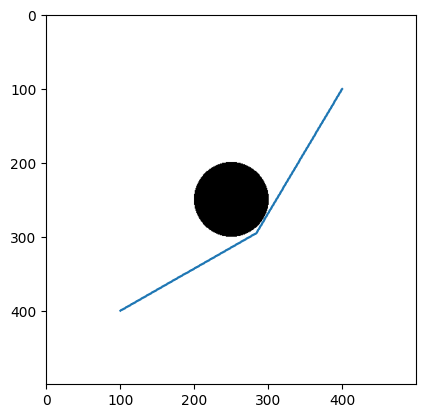

map1-GWO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


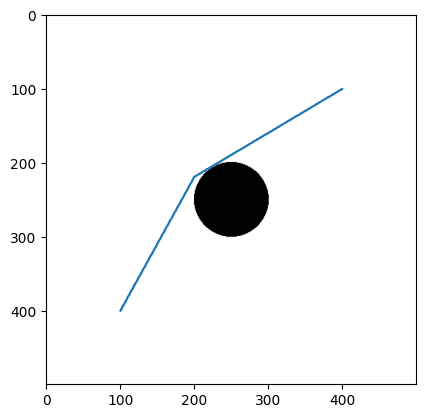

map1-GWO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


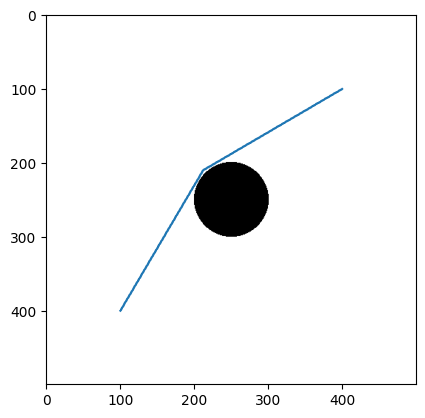

map1-PSO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


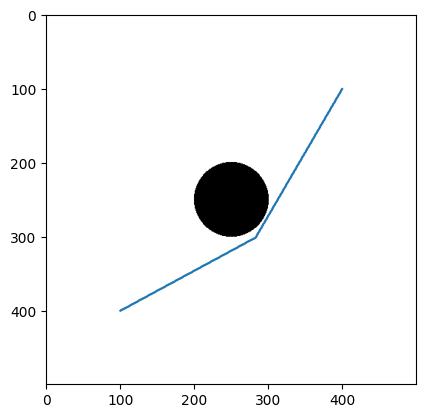

map1-PSO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


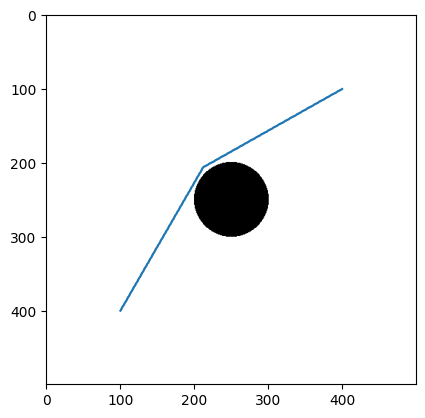

map1-PSO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


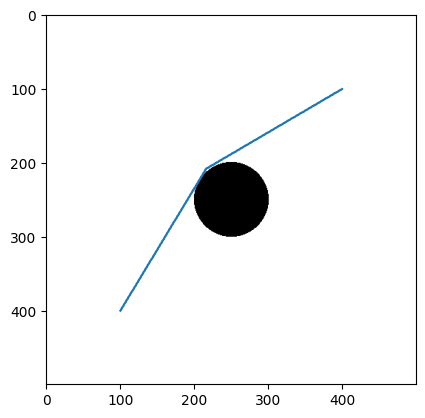

map1-PSO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


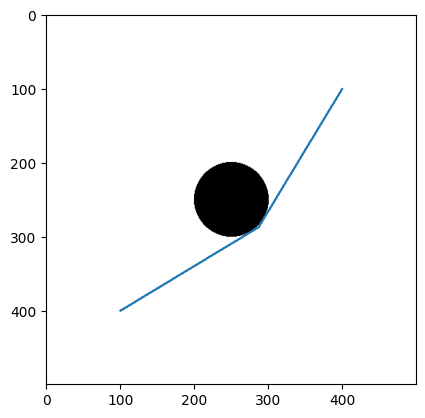

map1-PSO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


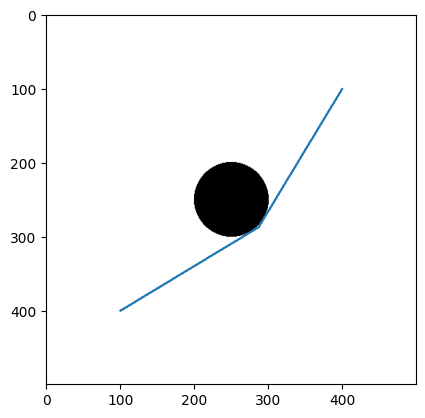

map2-ABC Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


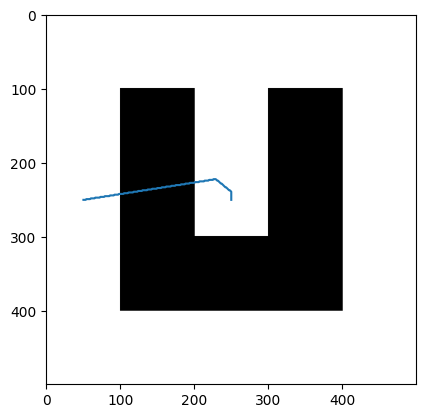

map2-ABC Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


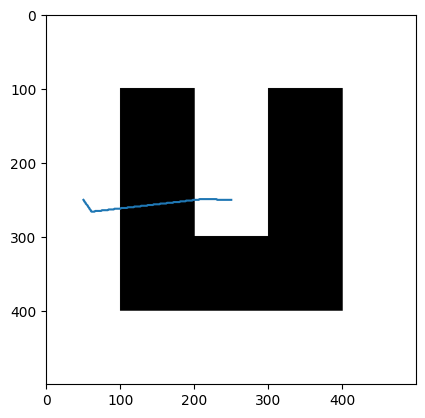

map2-ABC Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


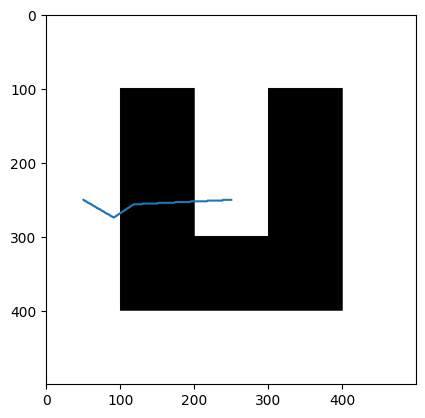

map2-ABC Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


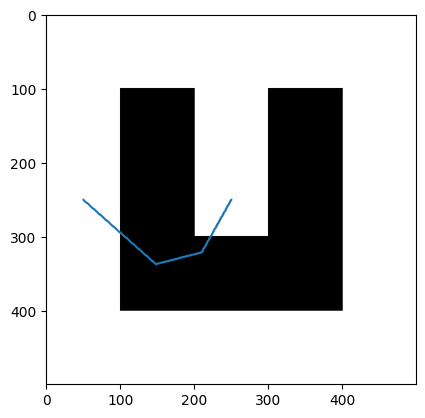

map2-ABC Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


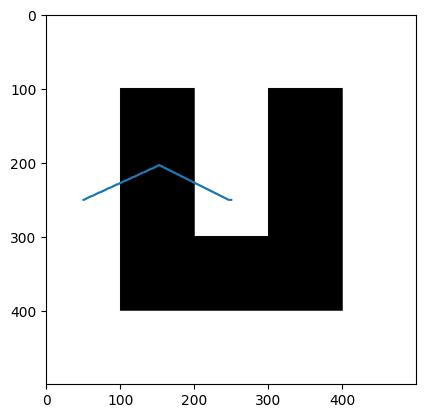

map2-GWO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


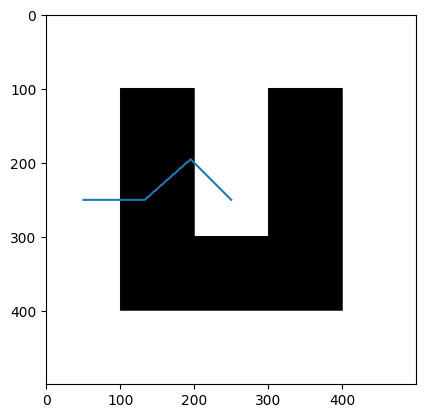

map2-GWO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


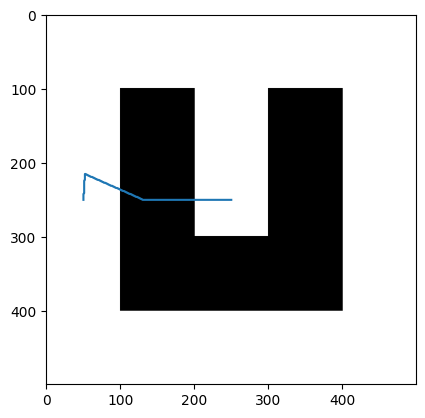

map2-GWO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


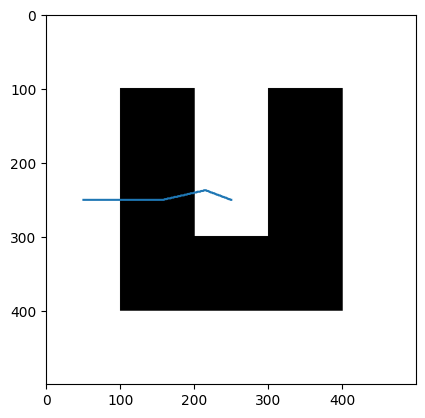

map2-GWO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


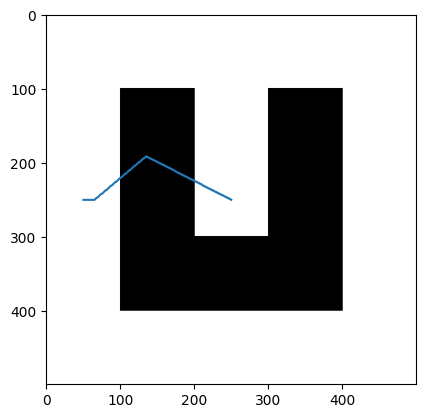

map2-GWO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


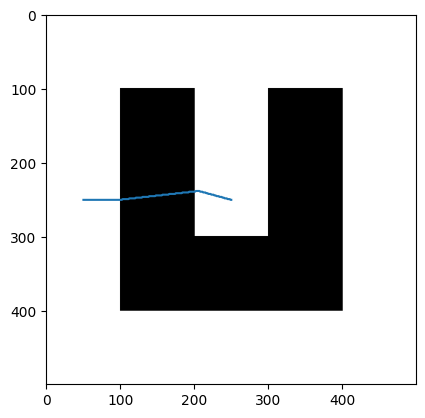

map2-PSO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


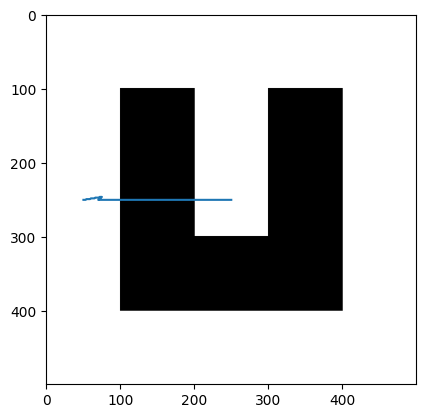

map2-PSO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


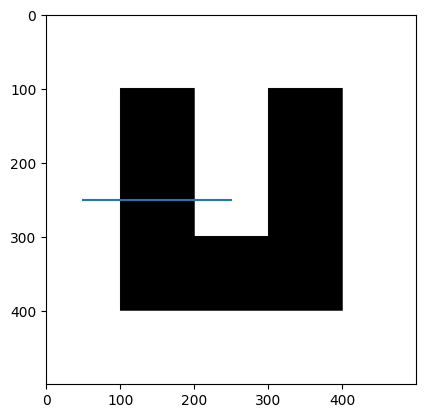

map2-PSO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


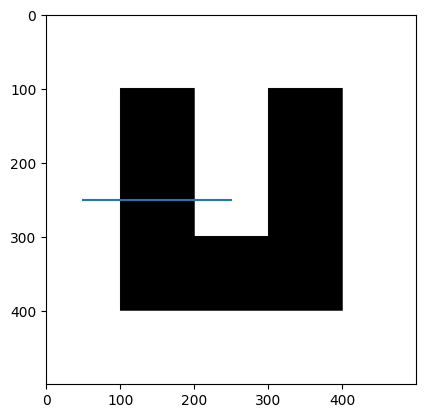

map2-PSO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


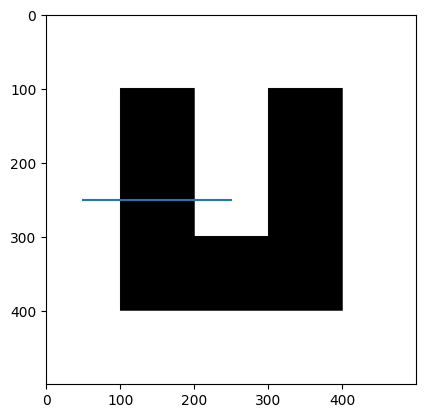

map2-PSO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


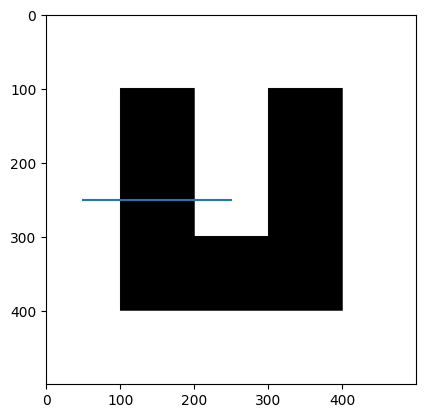

map3-ABC Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


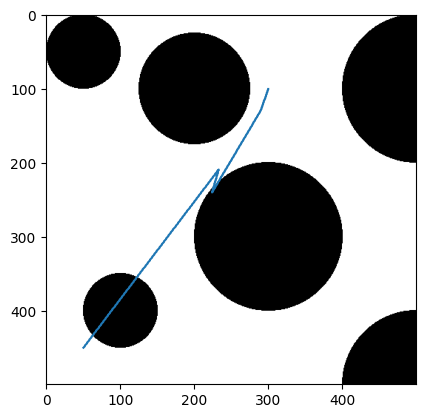

map3-ABC Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


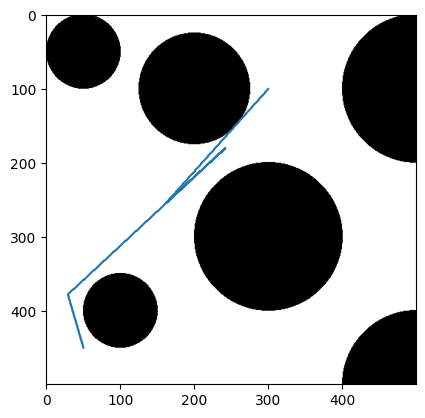

map3-ABC Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


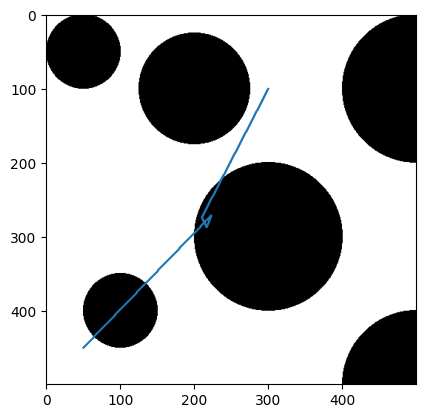

map3-ABC Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


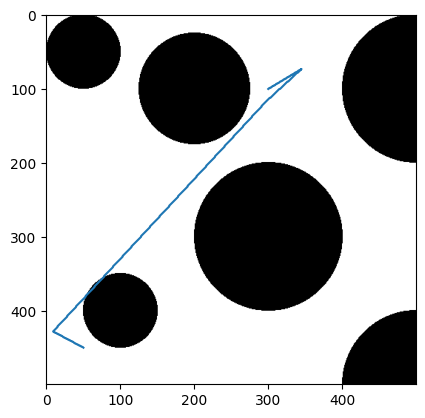

map3-ABC Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


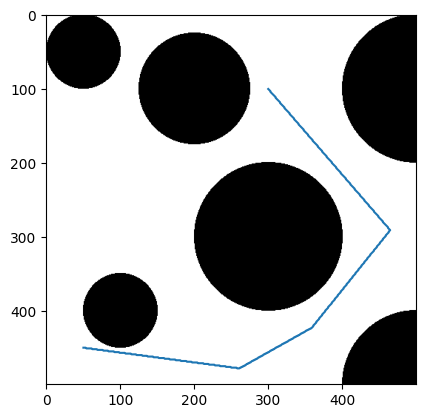

map3-GWO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


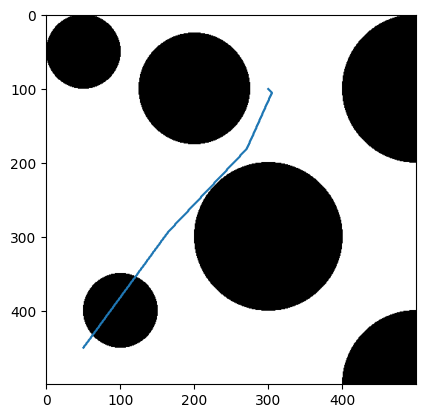

map3-GWO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


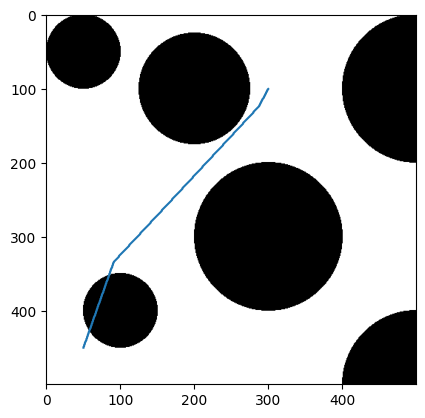

map3-GWO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


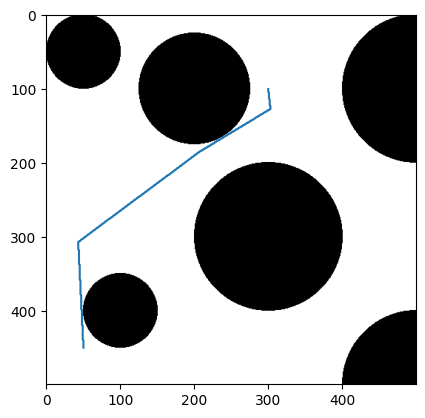

map3-GWO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


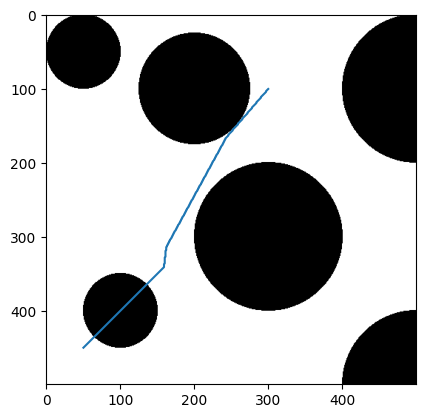

map3-GWO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


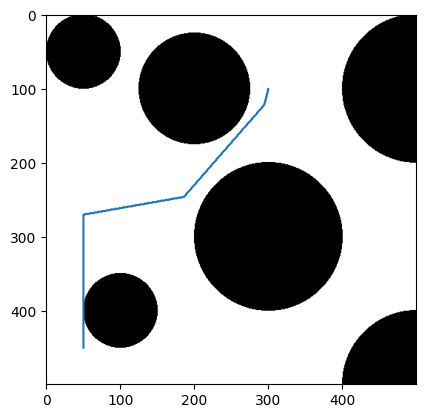

map3-PSO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


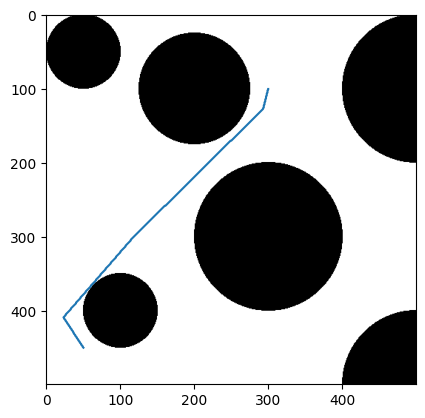

map3-PSO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


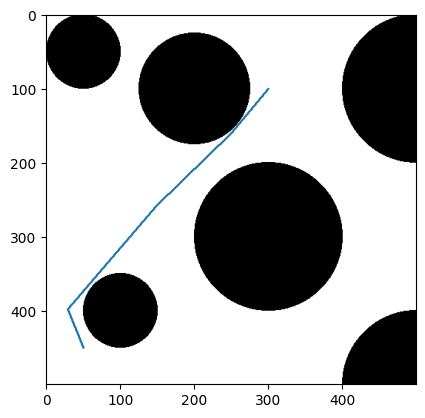

map3-PSO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


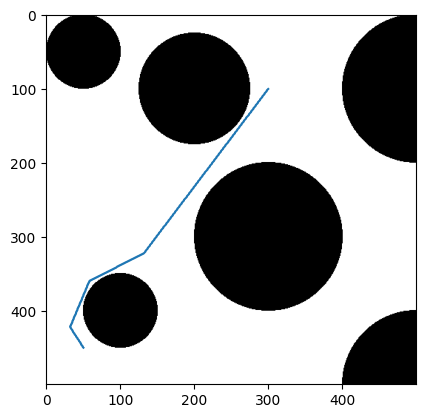

map3-PSO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


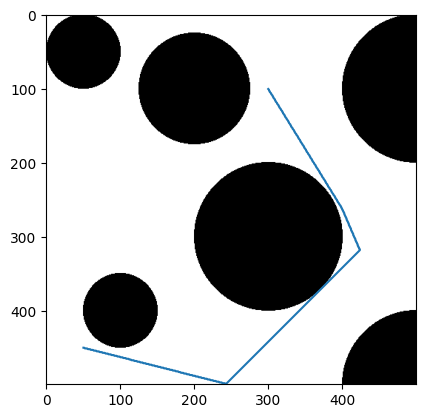

map3-PSO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


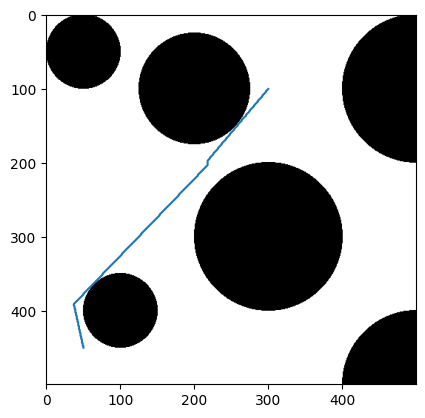

map4-ABC Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


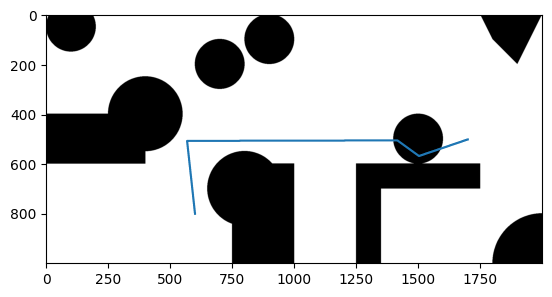

map4-ABC Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


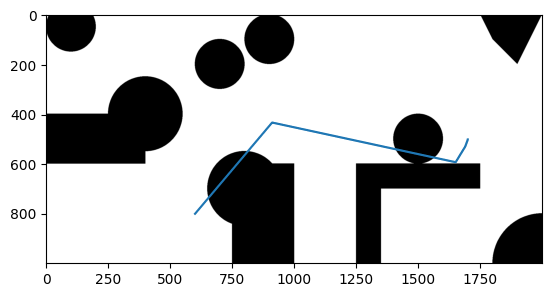

map4-ABC Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


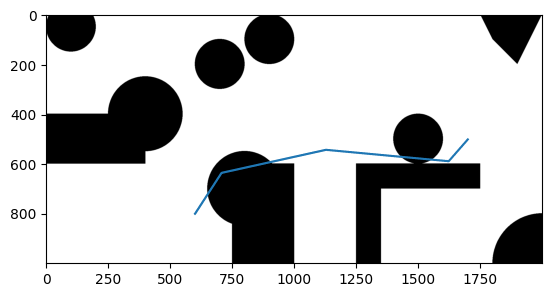

map4-ABC Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


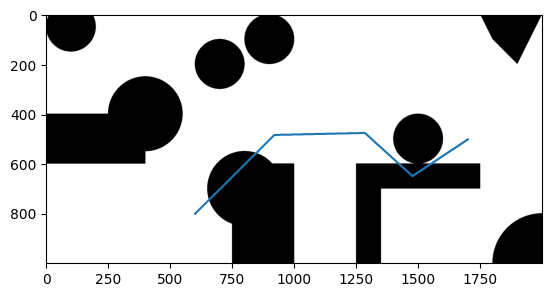

map4-ABC Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


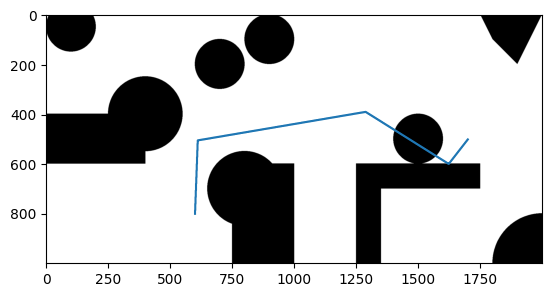

map4-GWO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


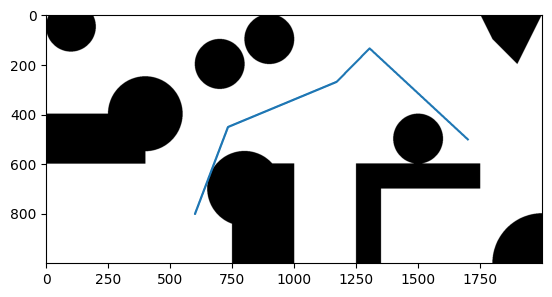

map4-GWO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


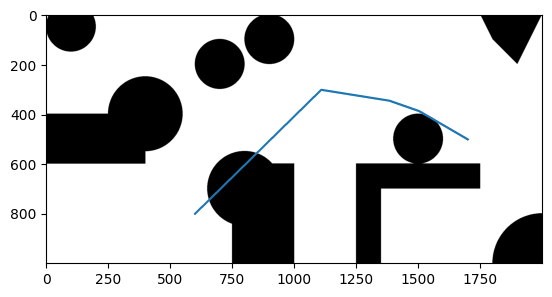

map4-GWO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


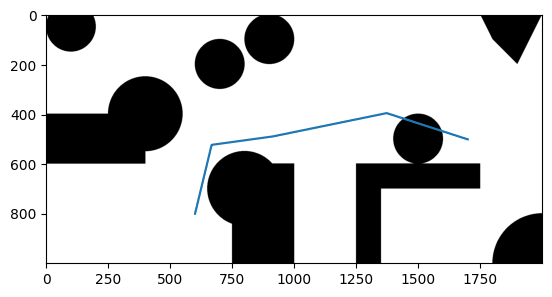

map4-GWO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


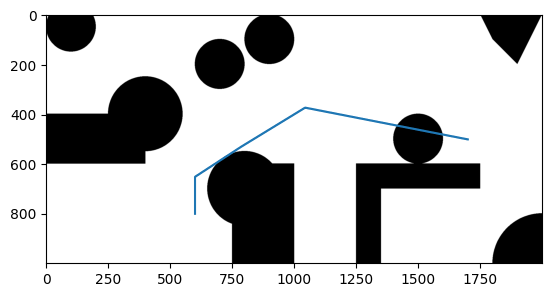

map4-GWO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


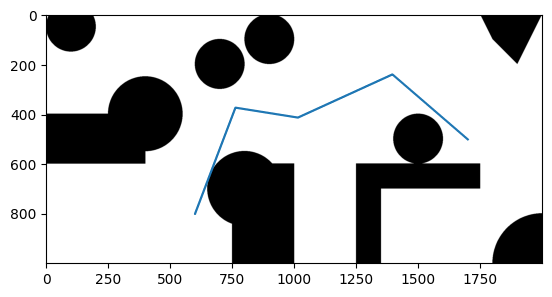

map4-PSO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


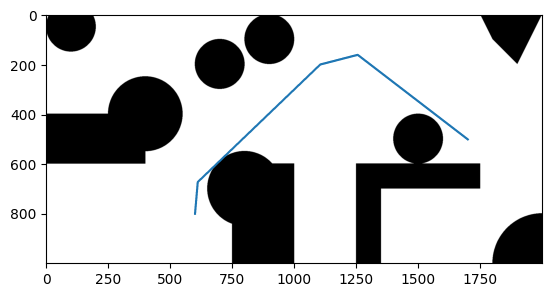

map4-PSO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


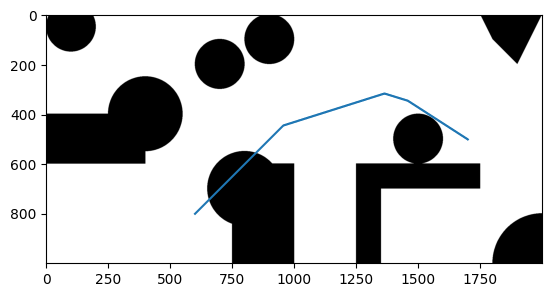

map4-PSO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


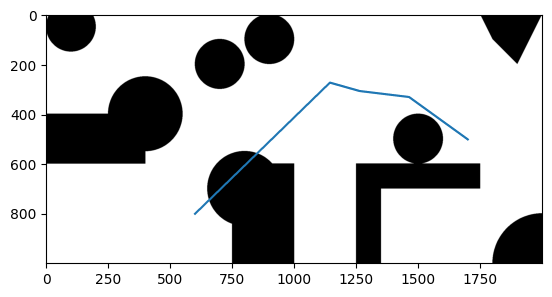

map4-PSO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


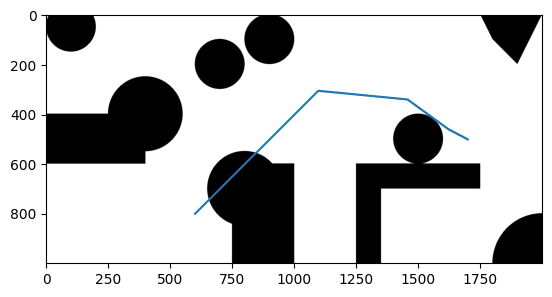

map4-PSO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


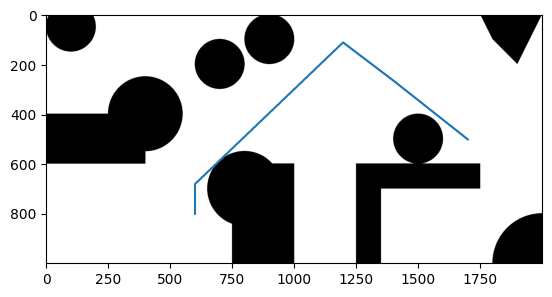

map5-ABC Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


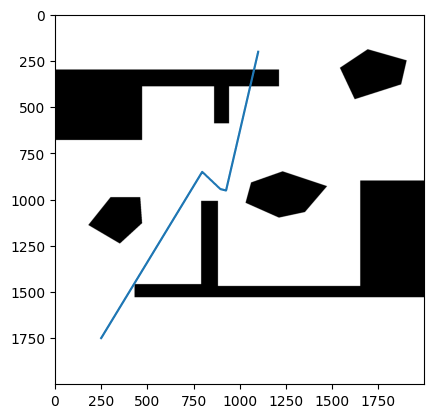

map5-ABC Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


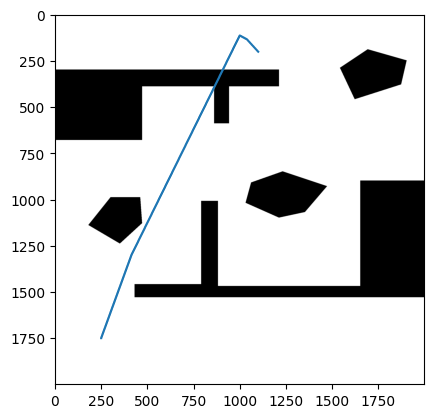

map5-ABC Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


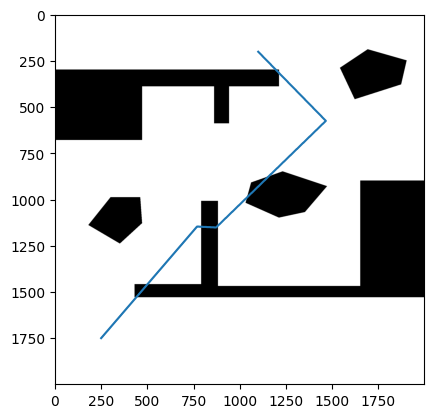

map5-ABC Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


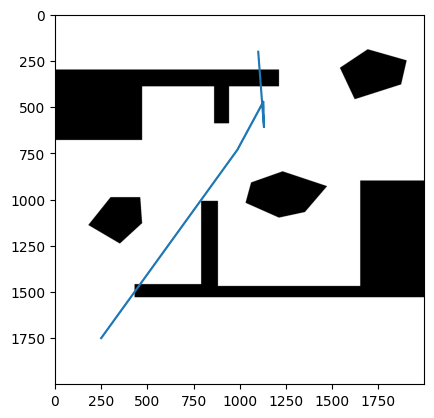

map5-ABC Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


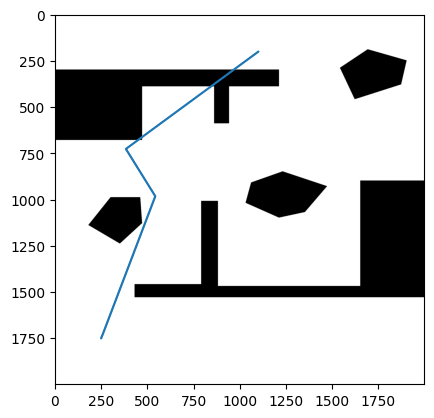

map5-GWO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


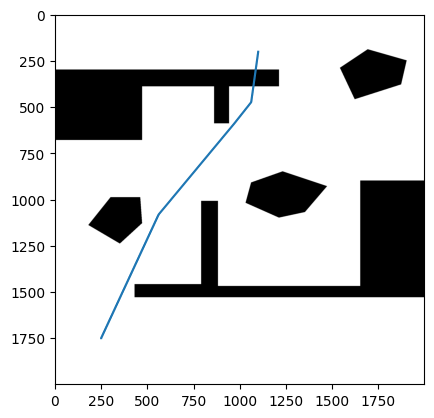

map5-GWO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


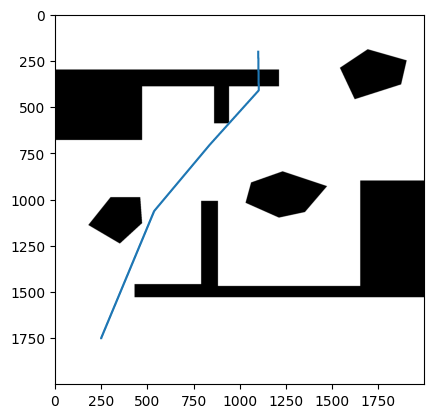

map5-GWO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


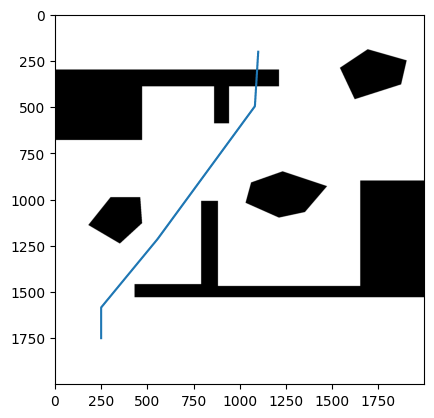

map5-GWO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


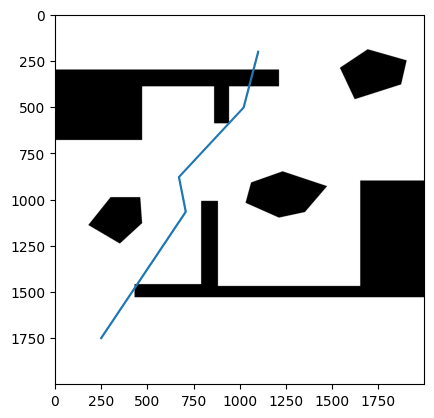

map5-GWO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


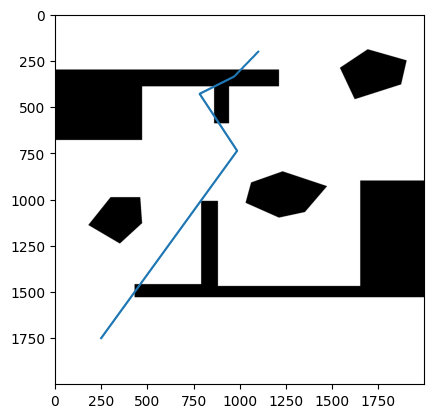

map5-PSO Optimizer-1
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


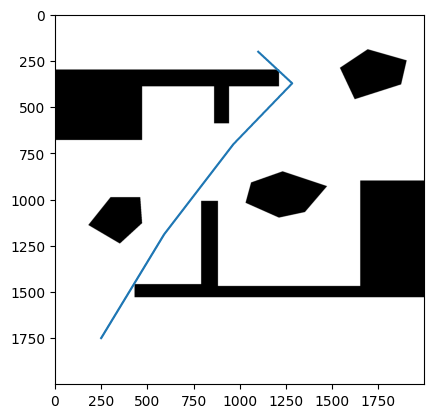

map5-PSO Optimizer-2
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


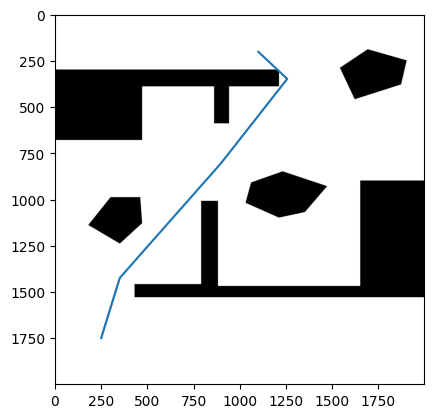

map5-PSO Optimizer-3
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


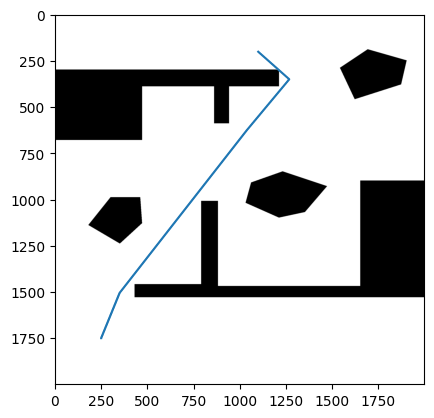

map5-PSO Optimizer-4
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


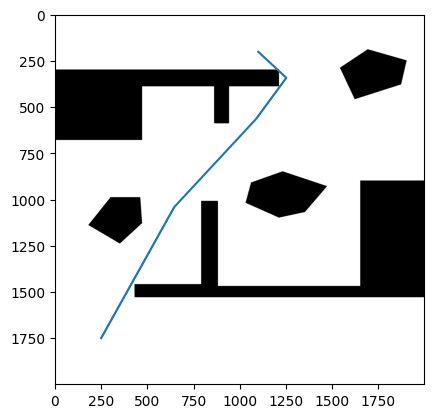

map5-PSO Optimizer-5
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40


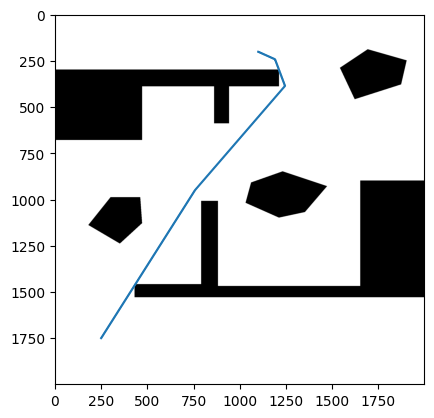

In [41]:
for map_name in map_details.keys():
    curr_details = map_details[map_name]
    
    file_name = curr_details['file_name']
    map_file_name = file_name.split('.')[0]
    map_gen = MapGenerator(os.path.join('map_params', file_name))
    curr_map = map_gen.map.get_map()
    
    start = np.array(curr_details['start']).astype(np.int32)
    end = np.array(curr_details['end']).astype(np.int32)
    
    for planner_name in planner_params.keys():
        curr_params = planner_params[planner_name]
        curr_params['map'] = curr_map
        
        opt_params = curr_params['optimizer_params']
        opt_params['points'] = curr_details['points']
        
        for i in range(total_runs):
            run = i + 1
            print(map_name, planner_name, run, sep='-')
            opt_params['iteration_callback'] = warehouse.get_callback(map_file_name, planner_name, run)
            planner = PlannerBase(**curr_params)
            start_time = time.time()
            path = planner.get_path(start, end)
            end_time = time.time()
            elapsed_time = end_time - start_time
            path_length, violations = get_path_cost(curr_map, path)
            results.loc[len(results)] = [map_file_name, planner_name, run, elapsed_time, path_length, violations]
            plt.imshow(curr_map, cmap='gray')
            plt.plot(path[:, 0], path[:, 1])
            plt.show()

In [17]:
results

,map_file,planner_name,run,time_taken,distance,violation
0,custom_map_2_params,ABC Optimizer,1,2.446561,548.714862,0
1,custom_map_2_params,ABC Optimizer,2,2.215588,532.744299,0
2,custom_map_2_params,ABC Optimizer,3,2.541760,563.614357,0
3,custom_map_2_params,ABC Optimizer,4,2.188429,570.099639,0
4,custom_map_2_params,ABC Optimizer,5,2.342785,552.543289,0
...,...,...,...,...,...,...
70,map_012_params,PSO Optimizer,1,4.115931,2286.369117,1
71,map_012_params,PSO Optimizer,2,4.108127,2150.112191,1
72,map_012_params,PSO Optimizer,3,3.950366,2198.232032,1
73,map_012_params,PSO Optimizer,4,4.245894,2201.634052,0


In [34]:
unique_maps = results['map_file'].unique()
unique_planners = results['planner_name'].unique()
for map_name in unique_maps:
    print('Current Map:', map_name)
    save_results = pd.DataFrame({
        'planner_name': pd.Series(dtype='str'),
        'avg_time': pd.Series(dtype='float'),
        'avg_distance': pd.Series(dtype='float'),
        'avg_violation': pd.Series(dtype='float')
    })
    curr_map_df = results[results['map_file'] == map_name]
    for planner_name in unique_planners:
        curr_df = curr_map_df[curr_map_df['planner_name'] == planner_name]
        avg_time = np.mean(curr_df['time_taken'])
        avg_distance = np.mean(curr_df['distance'])
        avg_violation = np.mean(curr_df['violation'])
        save_results.loc[len(save_results)] = [planner_name, avg_time, avg_distance, avg_violation]
    warehouse.save_result(map_name+'.csv', save_results)
    print(save_results)
    print('')

Current Map: custom_map_2_params
    planner_name  avg_time  avg_distance  avg_violation
0  ABC Optimizer  2.347024    553.543289            0.0
1  GWO Optimizer  1.092062    528.387950            0.0
2  PSO Optimizer  1.044744    517.778196            0.0

Current Map: custom_map_4_params
    planner_name  avg_time  avg_distance  avg_violation
0  ABC Optimizer  2.155596    280.469711            1.0
1  GWO Optimizer  0.727395    234.308658            1.0
2  PSO Optimizer  0.775596    231.266609            1.0

Current Map: custom_map_3_params
    planner_name  avg_time  avg_distance  avg_violation
0  ABC Optimizer  2.961979    682.705353            1.0
1  GWO Optimizer  1.204863    582.730086            1.2
2  PSO Optimizer  1.088859    505.142871            0.2

Current Map: custom_map_1_params
    planner_name  avg_time  avg_distance  avg_violation
0  ABC Optimizer  7.489164   1826.686967            1.2
1  GWO Optimizer  3.225335   1826.749709            1.4
2  PSO Optimizer  3.38876